In [1]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

# Einlesen der Pickle-Dateien und Vorverarbeitung des Inhaltes

In [2]:
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D1_I7000_F9000/TPath_500_finish_data_D1.pkl')
data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00199,500,7000,9000,675.83
2,0.0000,-0.00198,500,7000,9000,682.81
3,0.0000,-0.00197,500,7000,9000,689.82
4,0.0000,-0.00196,500,7000,9000,696.80
...,...,...,...,...,...,...
100646,0.0025,0.00196,500,7000,9000,578.47
100647,0.0025,0.00197,500,7000,9000,576.89
100648,0.0025,0.00198,500,7000,9000,575.32
100649,0.0025,0.00199,500,7000,9000,573.76


In [3]:
df = data.drop(data.columns[2:5], axis = 1)
df['Temperatur'].describe()

count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen
print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
83145       0.00207      -0.00062      1282.2
66701       0.00166      -0.00065      1347.6
91325       0.00227       0.00098      1094.6
46593       0.00116      -0.00123      1175.7
49518       0.00123      -0.00005      1459.2
...             ...           ...         ...
6265        0.00015       0.00050      1439.1
54886       0.00136       0.00150       876.7
76820       0.00191       0.00029      1335.8
860         0.00002      -0.00142      1071.2
15795       0.00039      -0.00044      1488.1

[100651 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00207,-0.00062,1282.2
1,0.00166,-0.00065,1347.6
2,0.00227,0.00098,1094.6
3,0.00116,-0.00123,1175.7
4,0.00123,-0.00005,1459.2
...,...,...,...
100646,0.00015,0.00050,1439.1
100647,0.00136,0.00150,876.7
100648,0.00191,0.00029,1335.8
100649,0.00002,-0.00142,1071.2


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X.describe()

,X-Koordinate,Y-Koordinate
count,100651.000000,1.006510e+05
mean,0.001250,1.103042e-20
std,0.000725,1.157589e-03
min,0.000000,-2.000000e-03
25%,0.000620,-1.000000e-03
50%,0.001250,4.529900e-18
75%,0.001880,1.000000e-03
max,0.002500,2.000000e-03


In [7]:
y.describe()


count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter


scaler_target = MinMaxScaler()

y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[0.416 , 0.5725],
       [0.812 , 0.7325],
       [0.628 , 0.5075],
       ...,
       [0.604 , 0.3875],
       [0.748 , 0.65  ],
       [0.028 , 0.6225]])

# Ende der Datenvorverarbeitung

# Machine Learning Modell mit Konfiguration je nach Dateiname

In [21]:
start_time = time.time()
# Netzwerkarchitektur
model = Sequential([
    # Eingabeschicht

    Dense(256, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(160, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(224, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(320, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(1 , activation = 'linear')
    
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min', restore_best_weights=True)#, min_delta = 0.00005)

# Trainingsparameter
batch_size = 100
epochs = 2000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose = 1)

end_time = time.time()

# Berechne die Dauer
duration = end_time - start_time

print(f"Die Ausführungszeit betrug {duration} Sekunden.")

Epoch 1/2000
645/645 [==============================] - 6s 6ms/step - loss: 0.1514 - mae: 0.2811 - val_loss: 0.1154 - val_mae: 0.2352
Epoch 2/2000
645/645 [==============================] - 4s 6ms/step - loss: 0.0701 - mae: 0.1580 - val_loss: 0.0378 - val_mae: 0.0846
Epoch 3/2000
645/645 [==============================] - 4s 6ms/step - loss: 0.0293 - mae: 0.0497 - val_loss: 0.0254 - val_mae: 0.0285
Epoch 4/2000
645/645 [==============================] - 3s 5ms/step - loss: 0.0244 - mae: 0.0219 - val_loss: 0.0235 - val_mae: 0.0160
Epoch 5/2000
645/645 [==============================] - 4s 7ms/step - loss: 0.0230 - mae: 0.0132 - val_loss: 0.0226 - val_mae: 0.0103
Epoch 6/2000
645/645 [==============================] - 4s 6ms/step - loss: 0.0222 - mae: 0.0090 - val_loss: 0.0218 - val_mae: 0.0075
Epoch 7/2000
645/645 [==============================] - 4s 5ms/step - loss: 0.0215 - mae: 0.0070 - val_loss: 0.0212 - val_mae: 0.0069
Epoch 8/2000
645/645 [==============================] - 3s 5ms

KeyboardInterrupt: 

 # k-Fold Crossvalidation 
Für die Performancebestimmung der unterschiedlichen Netzarchitekturen

In [11]:
# # Initialisiere Listen, um Ergebnisse zu speichern
# val_loss_results = []
# val_mae_results = []
# 
# # Funktion, um das Modell zu erstellen
# def create_model():
#     model = Sequential([
#             Dense(256, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
# 
#             Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(160, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(224, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(320, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(112, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
#         
#             Dense(1 , activation = 'linear')
#     ])
#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # K-Fold Cross-Validation Konfiguration
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# 
# # Leistungsüberwachung
# fold_no = 1
# for train_index, val_index in kf.split(X_train_scaled):
#     X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
#     y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]
# 
#     model = create_model()
# 
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
# 
#     print(f'Training für Fold {fold_no}...')
#     history = model.fit(X_train_fold, y_train_fold, batch_size=100, epochs=1000, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)
# 
#     # Speichere die Ergebnisse des aktuellen Folds
#     val_loss_results.append(min(history.history['val_loss']))
#     val_mae_results.append(min(history.history['val_mae']))
# 
#     fold_no += 1
# 
# # Berechne den Durchschnitt über alle Folds
# average_val_loss = np.mean(val_loss_results)
# average_val_mae = np.mean(val_mae_results)
# 
# # Gib die durchschnittlichen Ergebnisse aus
# print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
# print(f'Durchschnittlicher Validation MAE: {average_val_mae}')


Training für Fold 1...
Epoch 1/1000
645/645 [==============================] - 4s 3ms/step - loss: 0.2649 - mae: 0.1118 - val_loss: 0.1930 - val_mae: 0.0173
Epoch 2/1000
645/645 [==============================] - 2s 3ms/step - loss: 0.1722 - mae: 0.0103 - val_loss: 0.1561 - val_mae: 0.0194
Epoch 3/1000
645/645 [==============================] - 2s 3ms/step - loss: 0.1449 - mae: 0.0107 - val_loss: 0.1364 - val_mae: 0.0232
Epoch 4/1000
645/645 [==============================] - 2s 3ms/step - loss: 0.1292 - mae: 0.0106 - val_loss: 0.1234 - val_mae: 0.0161
Epoch 5/1000
645/645 [==============================] - 2s 3ms/step - loss: 0.1186 - mae: 0.0104 - val_loss: 0.1139 - val_mae: 0.0046
Epoch 6/1000
645/645 [==============================] - 2s 3ms/step - loss: 0.1101 - mae: 0.0079 - val_loss: 0.1063 - val_mae: 0.0118
Epoch 7/1000
645/645 [==============================] - 2s 3ms/step - loss: 0.1028 - mae: 0.0098 - val_loss: 0.0992 - val_mae: 0.0099
Epoch 8/1000
645/645 [=================

 # Auswertung des NeuroNetz auf den Testdatensatz

In [13]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

630/630 - 1s - loss: 1.6024e-04 - mae: 9.9540e-04 - 708ms/epoch - 1ms/step


[0.00016024254728108644, 0.000995395821519196]

In [22]:
#Rückrechnung des skalierten MAE zum unskalierten MAE für eines bessere Einschätzung des Ergebnisses
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[1000]} Actual: {original_actual_values[1000]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [1196.8182] Actual: [1195.9] 
Durchschnittliche Abweichung (MAE): [0.86373995]


In [14]:
#Berechnung der Auswertungsgröße R^2

def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99996729]


In [15]:
#Ausgabe der höchsten Abweichungen zwischen Echt und Vorhergesagt
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > 20).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 0


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
19281,792.087280,807.84,1.000,0.9125,-15.752720
15566,755.493835,771.22,0.996,0.9250,-15.726165
14143,817.607849,832.75,1.000,0.9025,-15.142151
11539,718.026611,733.08,0.996,0.9375,-15.053389
16514,823.933533,838.63,1.000,0.9000,-14.696467
...,...,...,...,...,...
14570,688.558289,675.50,0.944,0.0025,13.058289
13809,606.992004,593.15,0.988,0.9750,13.842004
1409,680.694214,666.57,0.936,0.0000,14.124214
7694,681.957275,667.48,0.944,0.0000,14.477275


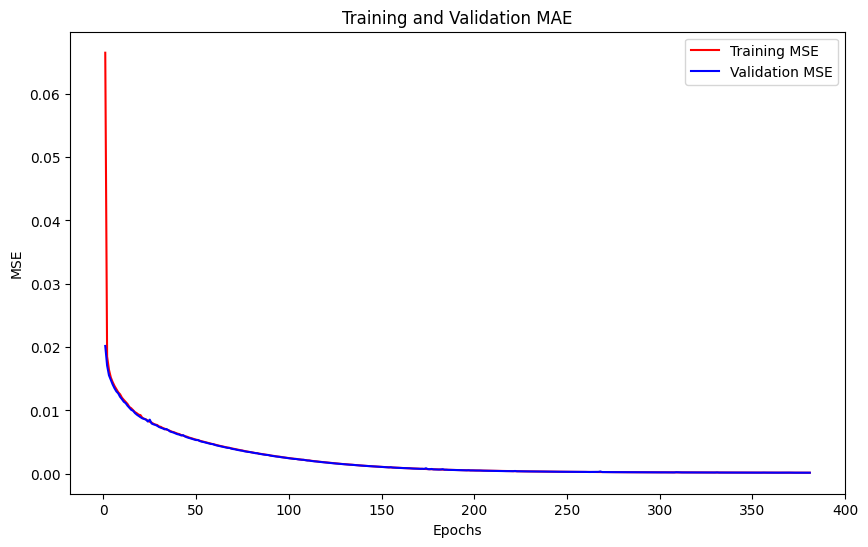

In [16]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)
# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Bilder Diplomarbeit/MSE_NeuroNetz/MSE_NeuroNetz_D1_2')
plt.show()



# GridSearch
Grid Search bietet die Vorteile der anpassbaren Rechenzeit sowie die Möglichkeit des EInsatzes von Verteilungen. So können theoretisch Hyperparamterkonfuigurationen gefunden wende, welche durch GridSearch nicht auffindbar wären. ZUdem ist das Ziel der Hyperparamteroptimierung eine Einstellung zu finden, welche auf Trainings und Testset gut angepasst ist. Die EInstellung muss nicht die bestmöglichste Einstellung sein, sondern eine Einstellung die das gewähltre Problem gut wiederspiegelt. 
Bayesian Optimierung

In [59]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(320, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(176, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(288, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(192, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(208, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(224, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(80, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(304, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate)) 
# 
#     model.add(Dense(240, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))   
# 
#     model.add(Dense(48, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001],
#     'fit__batch_size': [100, 200, 400, 800],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("grid_search_D1_2.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


# Random Search Architektur
Tiefes Netz besser als breites Netz; Layer lernen auf unterschiedliche Weise

In [61]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D1_{run}'
# 
#     tuner = RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=1,
#         directory=directory,
#         project_name=project_name
#     )
# 
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=500, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
# 
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
# 
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
# 
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D1_{run}.csv', index=False)
#     best_model.describe()
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")